# Modeling air pollution

Let us try to predict Beijing's air pollution, especially [PM2.5](https://en.wikipedia.org/wiki/Particulates) values in advance!


Inspiration comes from [here](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/).

## Dataset

[Beijing PM2.5 Data Data Set](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data)

### Columns of the dataset:

**No:** row number

**year:** year of data in this row

**month:** month of data in this row

**day:** day of data in this row

**hour:** hour of data in this row

**pm2.5:** PM2.5 concentration

**DEWP:** Dew Point

**TEMP:** Temperature

**PRES:** Pressure

**cbwd:** Combined wind direction

**Iws:** Cumulated wind speed

**Is:** Cumulated hours of snow

**Ir:** Cumulated hours of rain

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv

--2023-05-14 14:07:42--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010492 (1,9M) [text/plain]
Saving to: ‘pollution.csv’

pollution.csv       100%[===================>]   1,92M  2,66MB/s    in 0,7s    

2023-05-14 14:07:43 (2,66 MB/s) - ‘pollution.csv’ saved [2010492/2010492]



In [2]:
!pip install seglearn

In [3]:
import pandas as pd 
import csv
import numpy as np 
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("ignore")


In [4]:
def sniff_format(location):
    with open(location, newline='') as csvfile:
        sniffer = csv.Sniffer()
        sample = csvfile.read(1024)
        dialect = sniffer.sniff(sample)
        header = sniffer.has_header(sample)
        if header:
            header=0
        else:
            header=None

    return {"dialect":dialect, "header":header}

def describe_full(df):
    #pd.options.display.float_format = '{:.2f}'.format
    dtypes_description=pd.DataFrame(dict(df.dtypes),["dtypes"])
    na_description = pd.DataFrame(dict(df.isna().sum()),["NA-s"])
    na_percent = ((pd.DataFrame(dict(df.isna().sum()),["NA%"])/len(df))*100).round(decimals=2)
    description = df.describe(include='all')
    full_description = dtypes_description.append(na_description).append(na_percent).append(description).replace(np.nan, '', regex=True)

    mask = full_description.loc["freq",:]==1
    full_description.at[["top"],mask.index[mask]]=""
    #TODO: scientific notation - could be nicer
    
    return full_description

In [5]:
csv_format = sniff_format("pollution.csv")

df = pd.read_csv("pollution.csv",header=csv_format["header"],dialect=csv_format["dialect"])

#There is a warning that would be worth investigationg, but for now, let's ignore it
import warnings
warnings.filterwarnings("ignore")

describe_full(df)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
dtypes,int64,int64,int64,int64,int64,float64,int64,float64,float64,object,float64,int64,int64
NA-s,0,0,0,0,0,2067,0,0,0,0,0,0,0
NA%,0.0,0.0,0.0,0.0,0.0,4.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count,43824.0,43824.0,43824.0,43824.0,43824.0,41757.0,43824.0,43824.0,43824.0,43824,43824.0,43824.0,43824.0
unique,,,,,,,,,,4,,,
top,,,,,,,,,,SE,,,
freq,,,,,,,,,,15290,,,
mean,21912.5,2012.0,6.523549,15.72782,11.5,98.613215,1.817246,12.448521,1016.447654,,23.88914,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.43344,12.198613,10.268698,,50.010635,0.760375,1.415867
min,1.0,2010.0,1.0,1.0,0.0,0.0,-40.0,-19.0,991.0,,0.45,0.0,0.0


In [6]:
#Safety assertions to ensure, that No is as it seems an index column sorted, series
pd.testing.assert_series_equal(df.No,df.No.sort_values())
np.testing.assert_array_equal((df.No-df.No[0]).values, np.arange(0,df.shape[0],1))
#Don't really need these if we decide to go for date based indexing

In [7]:
df.drop("No",axis=1, inplace=True)
df["date"]= pd.to_datetime(df['year'].astype(str)+'-'+df['month'].astype(str)+"-"+df["day"].astype(str)+"T"+df["hour"].astype(str).apply(lambda x: x.zfill(2)+":00"))
df.set_index(df.date, inplace=True)
df.drop("date", axis=1, inplace=True)
df.head(10)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
date,,,,,,,,,,,,
2010-01-01 00:00:00,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0


## Encoding day of week

We explicitly encode the day of week, since we assume that weekends and workdays behave differently.

In [8]:
df["dayofweek"]=df.index.dayofweek+1

# Decision about NaN-s

<AxesSubplot:xlabel='date'>

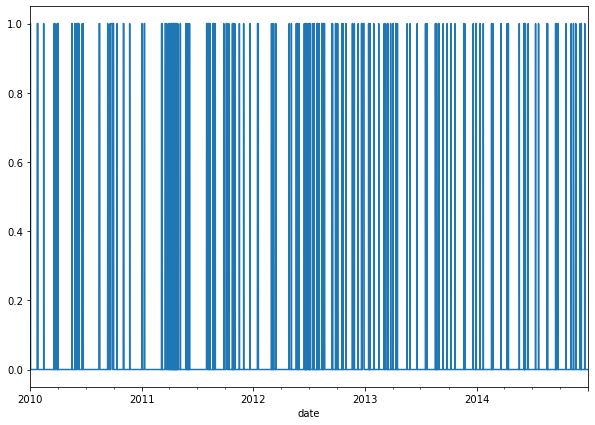

In [9]:
fig = plt.gcf()
fig.set_size_inches(10,7)
df["pm2.5"].isnull().astype(float).plot()

In [10]:
def isnullsum(df):
    return df.isnull().sum()
print("1-----")
print("% NaN datapoints per year:",(df.groupby(df.index.year)["pm2.5"].apply(isnullsum)/df.groupby(df.index.year)["pm2.5"].count())*100.0)

print("2--------------------------------")


print("% NaN datapoints per month:",(df.groupby(df.index.month)["pm2.5"].apply(isnullsum)/df.groupby(df.index.month)["pm2.5"].count())*100.0)

print("3--------------------------------")

print("% NaN datapoints per dayofweek:",(df.groupby(df.index.dayofweek)["pm2.5"].apply(isnullsum)/df.groupby(df.index.dayofweek)["pm2.5"].count())*100.0)

print("4--------------------------------")
print("% NaN datapoints per hour:",(df.groupby(df.index.hour)["pm2.5"].apply(isnullsum)/df.groupby(df.index.hour)["pm2.5"].count())*100.0)


1-----
% NaN datapoints per year: date
2010    8.268446
2011    9.063745
2012    5.895118
2013    0.944918
2014    1.143055
Name: pm2.5, dtype: float64
2--------------------------------
% NaN datapoints per month: date
1      7.173725
2      0.326119
3      4.611924
4      5.726872
5      3.075644
6      5.726872
7      2.001645
8     11.477375
9      8.010801
10     3.939648
11     2.827763
12     5.055069
Name: pm2.5, dtype: float64
3--------------------------------
% NaN datapoints per dayofweek: date
0    5.757218
1    5.596763
2    4.591752
3    3.809682
4    4.070444
5    4.977376
6    5.882353
Name: pm2.5, dtype: float64
4--------------------------------
% NaN datapoints per hour: date
0     5.244957
1     4.641834
2     5.002875
3     4.641834
4     4.701835
5     4.942529
6     4.942529
7     5.002875
8     5.063291
9     5.002875
10    5.305652
11    5.732484
12    5.488157
13    4.402516
14    5.123777
15    5.002875
16    5.123777
17    4.822044
18    4.283267
19    4.82204

After examining the NaN values in pm2.5, we see no obvious temporal pattern. This is cause for worry, since by simply dropping the rows with NaN values, we can destroy the temporal coherence of the data, hence **data imputation is desirable.**

The autocorrelation charts below imply, that it is not unreasonable to take the previous value to fill NaN-s (high autocorrelation with the previous timestep).

In [11]:

df.fillna(method='ffill', inplace=True)

print(df.isnull().sum())

df.dropna(inplace=True)

print(df.isnull().sum())


year          0
month         0
day           0
hour          0
pm2.5        24
DEWP          0
TEMP          0
PRES          0
cbwd          0
Iws           0
Is            0
Ir            0
dayofweek     0
dtype: int64
year         0
month        0
day          0
hour         0
pm2.5        0
DEWP         0
TEMP         0
PRES         0
cbwd         0
Iws          0
Is           0
Ir           0
dayofweek    0
dtype: int64


# Examining autocorrelations

<Figure size 432x288 with 0 Axes>

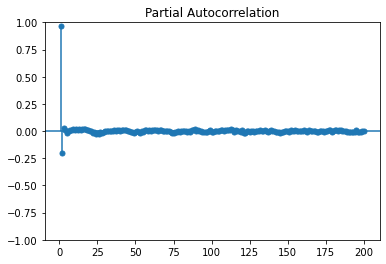

<Figure size 432x288 with 0 Axes>

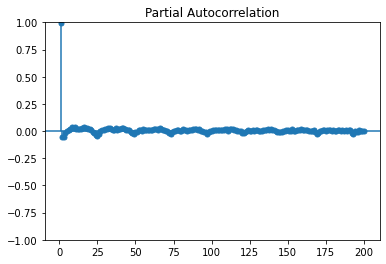

<Figure size 432x288 with 0 Axes>

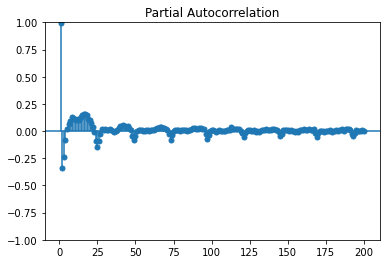

<Figure size 432x288 with 0 Axes>

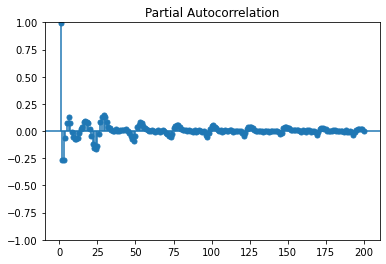

<Figure size 432x288 with 0 Axes>

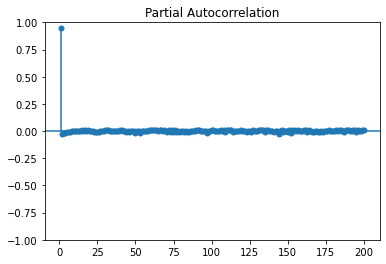

<Figure size 432x288 with 0 Axes>

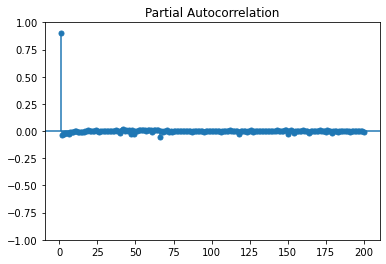

<Figure size 432x288 with 0 Axes>

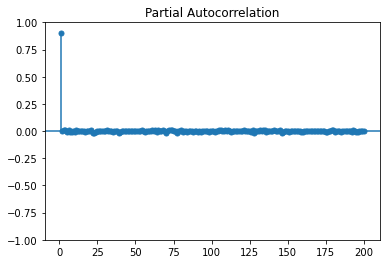

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

#columns = [] #use this for speedup
columns = ["pm2.5","DEWP","TEMP","PRES","Iws","Is","Ir"]

for col in columns:
    plt.figure()
    plot_pacf(df[col].dropna(), lags=200, zero=False)
    
plt.show()


## What do we see?

Well, the fact, that we don't see.

Or more precisely: smog (and weather) is slow to move, it is extremely strongly autocorrelated with itself one-two hours before, so in order to at least be able to see some autocorrelation structure beyond this, we need to filter out the first some hours from our autocorrelation analysis.

(By the way, that's why we don't stick to the prediction of the next hour as in the original "inspiration" blogpost. Would not be too relevant...)

In [15]:
from statsmodels.graphics.tsaplots import _prepare_data_corr_plot, _plot_corr
import statsmodels.graphics.utils as utils
from statsmodels.tsa.stattools import pacf

def plot_pacf_drop(x, ax=None, lags=None, alpha=.05, method='ywadjusted',
              use_vlines=True, title='Partial Autocorrelation', zero=True,
              vlines_kwargs=None, drop_no=0, **kwargs):
    
    lags_orig=lags
    fig, ax = utils.create_mpl_ax(ax)
    vlines_kwargs = {} if vlines_kwargs is None else vlines_kwargs
    lags, nlags, irregular = _prepare_data_corr_plot(x, lags, zero)
    confint = None
    if alpha is None:
        acf_x = pacf(x, nlags=nlags, alpha=alpha, method=method)
    else:
        acf_x, confint = pacf(x, nlags=nlags, alpha=alpha, method=method)

    if drop_no:
        acf_x = acf_x[drop_no+1:]
        confint = confint[drop_no+1:]
        lags, nlags, irregular = _prepare_data_corr_plot(x, lags_orig-drop_no, zero)
        
    _plot_corr(ax, title, acf_x, confint, lags, False, use_vlines,
               vlines_kwargs, **kwargs)

    return fig

<Figure size 432x288 with 0 Axes>

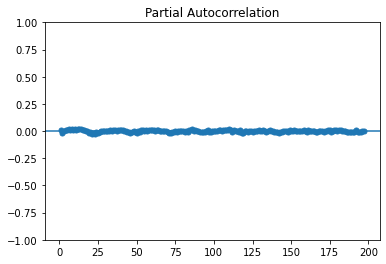

<Figure size 432x288 with 0 Axes>

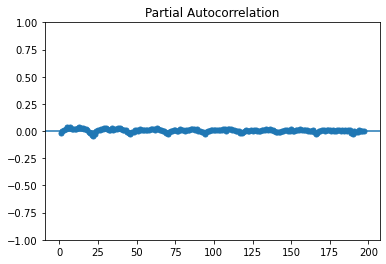

<Figure size 432x288 with 0 Axes>

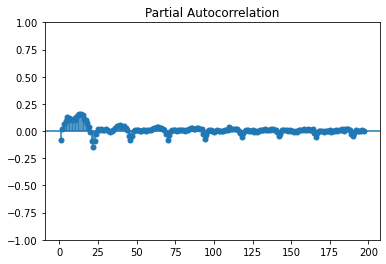

<Figure size 432x288 with 0 Axes>

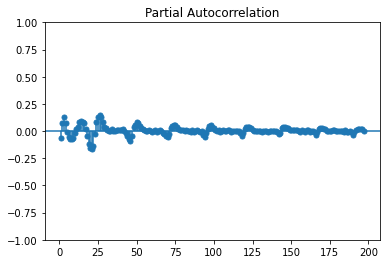

<Figure size 432x288 with 0 Axes>

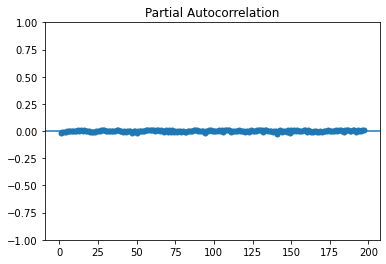

<Figure size 432x288 with 0 Axes>

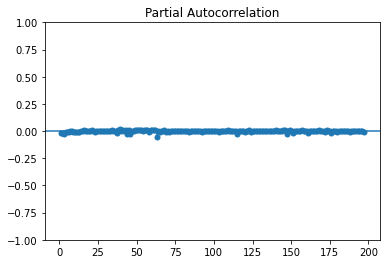

<Figure size 432x288 with 0 Axes>

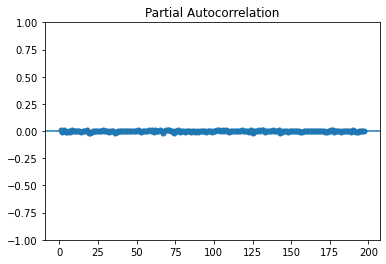

In [16]:
import matplotlib.pyplot as plt

#columns = [] #use this for speedup
columns = ["pm2.5","DEWP","TEMP","PRES","Iws","Is","Ir"]

for col in columns:
    plt.figure()
    plot_pacf_drop(df[col].dropna(), lags=200, drop_no=3, zero=False)
    
plt.show()


Studying even the filtered charts leaves us in doubt about the possible window for modeling (in case of the classical models), so we will keep 100 as the modeling window (nearly two weeks). This is a parameter that is worth empirically studying later on.

It is worth mentioning, that the `pacf` charts would definitely change drastically if we would use some differencing. Since down below we decide not to, we keep it as it is.

## Seasonal decomposition and the question of trends

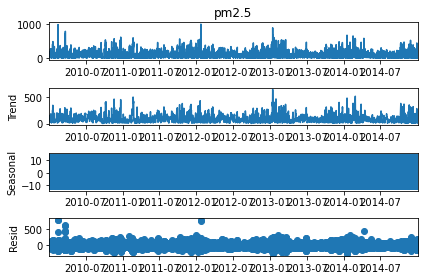

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import freq_to_period
import matplotlib.pyplot as plt

analysis = seasonal_decompose(df["pm2.5"], period=freq_to_period(df.index.inferred_freq))

analysis.plot()
plt.show()

Well, the default setting (infer periods - hourly) is rather uninformative, so it is maybe worth using some domain knowledge here, and use yearly frequency.

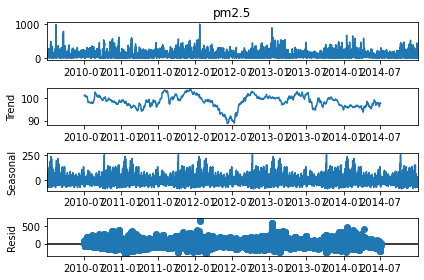

In [19]:
analysis = seasonal_decompose(df["pm2.5"], period=24*365)

analysis.plot()
plt.show()

We do get the first impression, that there is no overarching simple trend, as well as there are non-trivial seasonal patterns. At a later stage we should investigate differencing regimes, but for now, we leave the data as is.

# Train, valid, test split - before normalization

Contamination by the normalization values is a distant possibility, but let's stick to paranoid practices.

In [20]:
VALID_AND_TEST_SIZE=0.1

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_else, y_train, y_else = train_test_split(df, df["pm2.5"], test_size=VALID_AND_TEST_SIZE*2, shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_else, y_else, test_size=0.5, shuffle=False)


We could have used `temporal_split` from `seglearn`, but that would have cast everything to numpy, so it was more convenient this way for now. Using `seglearn` is encouraged - if we would like to go into classical modeling.

# Data normalization

Our default assumption is to use Scikit's minmax scaler for easier learning by neural models.

But there are some exceptions:

## How to normalize dates?

For the year it is more tricky, it is basically an ordinal.
Subtracting the first year is nice, but how to handle the normalization to 0,1?

We could use 2018 as a max, but **WE WOULD HAVE TO WRITE A BIG CAVEAT MESSAGE FOR DEPLOY PEOPLE!**

So it should be something like  `(df.year - (df.year.min())-1)/((df.year.max()-df.year.min())*2)` (-1 is for avoiding zero, making the life of the network more easy...)

For now we stick to the minmax scaler (living risky... :-)

For month, day, hour default assumption is, scikit's minmax scaler could work, but we will choose a more elaborate solution from [here](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/). This capitalizes on the circular nature of these quasi ordinals.


In [22]:
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# I literally hate when a standard Scikit function throws big bunches of warnings 
# - though suppressing them is a dangerous practice. Hence this comment. 

def minmax_scale(df_x,series_y, normalizers=None):
    features_to_minmax = ["year","pm2.5","DEWP","TEMP","PRES","Iws","Is","Ir"]

    if not normalizers:
        normalizers = {}

    for feat in features_to_minmax:
        if feat not in normalizers:
            normalizers[feat] = MinMaxScaler()
            normalizers[feat].fit(df_x[feat].values.reshape(-1, 1))
        
        df_x[feat] = normalizers[feat].transform(df_x[feat].values.reshape(-1, 1))

    series_y=normalizers["pm2.5"].transform(series_y.values.reshape(-1, 1))

    return df_x, series_y, normalizers

In [23]:

X_train_norm, y_train_norm, normalizers = minmax_scale(X_train, y_train)
X_valid_norm, y_valid_norm, _ = minmax_scale(X_valid, y_valid, normalizers=normalizers)
X_test_norm, y_test_norm, _ = minmax_scale(X_test, y_test, normalizers=normalizers)


## Encoding of ordinals

The encoding of `cbwd` is interesting, since it is an ordinal again, or better to say not even that, it has a nice circular topology, so we will use the same sin-cos solution.

Problem is, that there is a valid "zero" value, marked "cv" in there. We are tempted to replace that with 0.

In [24]:

def encode_cyclicals(df_x):
    #"month","day","hour", "cdbw", "dayofweek"
    
    DIRECTIONS = {"N":1.0,"NE":2.0, "E":3.0, "SE":4.0, "S":5.0, "SW":6.0, "W":7.0, "NW":8.0, "cv":np.nan}

    df_x['month_sin'] = np.sin(2*np.pi*df_x.month/12)
    df_x['month_cos'] = np.cos(2*np.pi*df_x.month/12)
    df_x.drop('month', axis=1, inplace=True)
    
    df_x['day_sin'] = np.sin(2*np.pi*df_x.day/31)
    df_x['day_cos'] = np.cos(2*np.pi*df_x.day/31)
    df_x.drop('day', axis=1, inplace=True)

    df_x['dayofweek_sin'] = np.sin(2*np.pi*df_x.dayofweek/7)
    df_x['dayofweek_cos'] = np.cos(2*np.pi*df_x.dayofweek/7)
    df_x.drop('dayofweek', axis=1, inplace=True)
    
    df_x['hour_sin'] = np.sin(2*np.pi*df_x.hour/24)
    df_x['hour_cos'] = np.cos(2*np.pi*df_x.hour/24)
    df_x.drop('hour', axis=1, inplace=True)
    
    df_x.replace({'cbwd': DIRECTIONS}, inplace=True)
    df_x['cbwd'] = df_x['cbwd'].astype(np.float64) 

    df_x['cbwd_sin'] = np.sin(2.0*np.pi*df_x.cbwd/8.0)
    df_x['cbwd_sin'].replace(np.nan, 0.0, inplace=True) #Let's handle the case with no wind specially
    df_x['cbwd_cos'] = np.cos(2.0*np.pi*df_x.cbwd/8.0)
    df_x['cbwd_cos'].replace(np.nan, 0.0, inplace=True) #Let's handle the case with no wind specially
    df_x.drop('cbwd', axis=1, inplace=True)
    
    return df_x

In [25]:
X_train_norm = encode_cyclicals(X_train_norm)
X_valid_norm = encode_cyclicals(X_valid_norm)
X_test_norm = encode_cyclicals(X_test_norm)

In [26]:
X_train_norm

,year,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,month_sin,month_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,cbwd_sin,cbwd_cos
date,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,0.0,0.129779,0.278689,0.250000,0.527273,0.002290,0.000000,0.0,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.781831,0.623490,0.000000,1.000000,1.224647e-16,-1.0
2010-01-02 01:00:00,0.0,0.148893,0.295082,0.250000,0.527273,0.003811,0.000000,0.0,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.781831,0.623490,0.258819,0.965926,1.224647e-16,-1.0
2010-01-02 02:00:00,0.0,0.159960,0.360656,0.233333,0.545455,0.005332,0.000000,0.0,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.781831,0.623490,0.500000,0.866025,1.224647e-16,-1.0
2010-01-02 03:00:00,0.0,0.182093,0.426230,0.233333,0.563636,0.008391,0.037037,0.0,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.781831,0.623490,0.707107,0.707107,1.224647e-16,-1.0
2010-01-02 04:00:00,0.0,0.138833,0.426230,0.233333,0.563636,0.009912,0.074074,0.0,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.781831,0.623490,0.866025,0.500000,1.224647e-16,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,1.0,0.022133,0.229508,0.433333,0.400000,0.195540,0.000000,0.0,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,-0.965926,0.258819,-2.449294e-16,1.0
2013-12-31 20:00:00,1.0,0.018109,0.196721,0.433333,0.418182,0.203948,0.000000,0.0,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,-0.866025,0.500000,-2.449294e-16,1.0
2013-12-31 21:00:00,1.0,0.023139,0.196721,0.433333,0.418182,0.213877,0.000000,0.0,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.974928,-0.222521,-0.707107,0.707107,-2.449294e-16,1.0


In [27]:
#Just in case to ensure we did everything right
assert all(x==np.float64 for x in list(X_train_norm.dtypes))

It would be worth checking with some assertions that the manual normalizers work well. Let's leave it to later work.

It is also worth noting, that the normalizers should be saved and used in production.

# Creating target (y) and "windows" (X) for modeling

By default we use the next 24 hour value of "pm2.5" for prediction, that is, I would like to predict what the pm2.5 will be like **at this hour 24 hours from now.**

We use the quite handy **seglearn** package for this.

Because of computational reasons, we **use the window of 100 hours** to predict. Classical models would have hard time to accommodate substantially (like 5-10x) context windows, LSTM-s would suffer from the challenge of long term memory. After a basic run of modeling the next big challenge would be to investigate PACF structure more and use eg. stateful LSTM modeling to try to accommodate the large "lookback".   

In [28]:
TIME_WINDOW=100
FORECAST_DISTANCE=24

In [29]:
from seglearn.transform import FeatureRep, SegmentXYForecast, last

segmenter = SegmentXYForecast(width=TIME_WINDOW, step=1, y_func=last, forecast=FORECAST_DISTANCE)

X_train_rolled, y_train_rolled,_=segmenter.fit_transform([X_train_norm.values],[y_train_norm.flatten()])

In [30]:
X_train_rolled[:1]

array([[[ 0.00000000e+00,  1.29778672e-01,  2.78688525e-01, ...,
          1.00000000e+00,  1.22464680e-16, -1.00000000e+00],
        [ 0.00000000e+00,  1.48893360e-01,  2.95081967e-01, ...,
          9.65925826e-01,  1.22464680e-16, -1.00000000e+00],
        [ 0.00000000e+00,  1.59959759e-01,  3.60655738e-01, ...,
          8.66025404e-01,  1.22464680e-16, -1.00000000e+00],
        ...,
        [ 0.00000000e+00,  7.74647887e-02,  1.31147541e-01, ...,
          9.65925826e-01,  1.00000000e+00,  6.12323400e-17],
        [ 0.00000000e+00,  5.03018109e-02,  1.14754098e-01, ...,
          8.66025404e-01,  1.00000000e+00,  6.12323400e-17],
        [ 0.00000000e+00,  4.42655936e-02,  1.14754098e-01, ...,
          7.07106781e-01,  1.00000000e+00,  6.12323400e-17]]])

# Classical modeling

## Baseline - DummyPredictor

In [31]:
X_train_rolled.shape

(34917, 100, 18)

In [32]:
shape = X_train_rolled.shape
X_train_flattened = X_train_rolled.reshape(shape[0],shape[1]*shape[2])
X_train_flattened.shape

(34917, 1800)

In [33]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor()

dummy_model.fit(X_train_flattened, y_train_rolled)

DummyRegressor()

### Evaluation

In [34]:
X_valid_rolled, y_valid_rolled,_=segmenter.fit_transform([X_valid_norm.values],[y_valid_norm.flatten()])

shape = X_valid_rolled.shape
X_valid_flattened = X_valid_rolled.reshape(shape[0],shape[1]*shape[2])

dummy_model_predictions = dummy_model.predict(X_valid_flattened)

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms_base = sqrt(mean_squared_error(y_valid_rolled, dummy_model_predictions))

print("Root mean squared error on valid:",rms_base)
print("Root mean squared error on valid inverse transformed from normalization:",normalizers["pm2.5"].inverse_transform(np.array([rms_base]).reshape(1, -1)))

Root mean squared error on valid: 0.0986950073704243
Root mean squared error on valid inverse transformed from normalization: [[98.10283733]]


## Fitting a RandomForest on raw data

In [36]:
from sklearn.ensemble import RandomForestRegressor

N_ESTIMATORS = 30
RANDOM_STATE = 452543634

In [37]:
RF_base_model = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=N_ESTIMATORS, n_jobs=-1, verbose=100)

RF_base_model.fit(X_train_flattened,y_train_rolled)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 30building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30

building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   31.7s
building tree 10 of 30[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   32.5s

building tree 11 of 30[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   33.0s

building tree 12 of 30[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   33.1s

building tree 13 of 30[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   33.3s

building tree 14 of 30[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   34.1s

building tree 15 of 30[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   34.2s

building tree 16 of 30[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   35.1s

building tree 17 of 30[Parallel(n_jobs=-1)]: Done   9 tasks     

RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=452543634,
                      verbose=100)

### Evaluation

WARNING: This is just a basic evaluation scheme, more thorough investigation needed!

In [38]:
RF_base_model_predictions = RF_base_model.predict(X_valid_flattened)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.0s
[Para

In [39]:
rms_base = sqrt(mean_squared_error(y_valid_rolled, RF_base_model_predictions))

print("Root mean squared error on valid:",rms_base)
print("Root mean squared error on valid inverse transformed from normalization:",normalizers["pm2.5"].inverse_transform(np.array([rms_base]).reshape(1, -1)))

Root mean squared error on valid: 0.08835802709609038
Root mean squared error on valid inverse transformed from normalization: [[87.82787893]]


## Fitting a RandomForest on feature transformed data

In [40]:
RF_feature_model = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=N_ESTIMATORS, n_jobs=-1, verbose=100)

feature_converter = FeatureRep()

RF_feature_model.fit(feature_converter.fit_transform(X_train_rolled),y_train_rolled)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s

building tree 10 of 30[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s

building tree 11 of 30[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.8s

building tree 12 of 30[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.1s

building tree 13 of 30[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.4s

building tree 14 of 30[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    5.5s

building tree 15 of 30[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.6s

[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.0s
building tree 16 of 30
building tree 17 of 30[Parallel(n_jobs=-1)]: Done   9 tasks     

RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=452543634,
                      verbose=100)

### Evaluation

WARNING: This is just a basic evaluation scheme, more thorough investigation needed!

In [41]:
X_valid_rolled, y_valid_rolled,_=segmenter.fit_transform([X_valid_norm.values],[y_valid_norm.flatten()])

RF_feature_model_predictions = RF_feature_model.predict(feature_converter.transform(X_valid_rolled))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.0s
[Para

In [42]:
rms_feature = sqrt(mean_squared_error(y_valid_rolled, RF_feature_model_predictions))

print("Root mean squared error on valid:",rms_feature)
print("Root mean squared error on valid inverse transformed from normalization:",normalizers["pm2.5"].inverse_transform(np.array([rms_feature]).reshape(1, -1)))

Root mean squared error on valid: 0.09913531688046091
Root mean squared error on valid inverse transformed from normalization: [[98.54050498]]


(Note: In a real life scenario, I would double check if the result of check inverse_transform is what I expect to be. Most probably is, but printing out error metrics is a sensitive part, one can easily fool oneself.)

## XGBoost for speedup

In [43]:
import xgboost as xgb

# XGBoost needs it's custom data format to run quickly
dmatrix_train = xgb.DMatrix(data=X_train_flattened,label=y_train_rolled)
dmatrix_valid = xgb.DMatrix(data=X_valid_flattened,label=y_valid_rolled)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
params = {'objective': 'reg:linear', 'eval_metric': 'rmse', 'n_estimators': 30, 'tree_method':'gpu_hist'}
#param['nthread'] = 4
evallist = [(dmatrix_valid, 'eval'), (dmatrix_train, 'train')]

#After some tests, it turned out to overfit after this point
num_round = 12

xg_reg = xgb.train(params, dmatrix_train, num_round, evallist)

In [ ]:
xgb_predictions = xg_reg.predict(dmatrix_valid)

rms_base = sqrt(mean_squared_error(y_valid_rolled, xgb_predictions))

print("Root mean squared error on valid:",rms_base)
print("Root mean squared error on valid inverse transformed from normalization:",normalizers["pm2.5"].inverse_transform(np.array([rms_base]).reshape(1, -1)))

### Forcing the issue with a bit of grid search

Since XGBoost fits quite quickly, especially on GPU, we can try to poke around a small grid of parameters, and see, if we can get some better results.

In [ ]:
from sklearn.model_selection import ParameterSampler, ParameterGrid

all_params = {
        #'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        #'subsample': [0.6, 0.8, 1.0],
        #'colsample_bytree': [0.6, 0.8, 1.0],
        #'max_depth': [3, 4, 5],
        'n_estimators':[30,100,200,500],
        'learning_rate':[0.01, 0.1, 0.2, 0.3],
        'objective': ['reg:linear'],
        'eval_metric': ['rmse'],
        'tree_method': ['gpu_hist'],
        }

best_score = 10000.0
run = 1

evallist = [(dmatrix_valid, 'eval'), (dmatrix_train, 'train')]
for param_sample in ParameterGrid(all_params):
    print("----RUN ",run)
    xg_reg = xgb.train(param_sample, dmatrix_train, num_round*3, evallist)
    
    xgb_predictions = xg_reg.predict(dmatrix_valid)
    score = sqrt(mean_squared_error(y_valid_rolled, xgb_predictions))

    if score < best_score:
        best_score = score
        best_model = xg_reg
    run+=1

print("Root mean squared error on valid:",best_score)
print("Root mean squared error on valid inverse transformed from normalization:",normalizers["pm2.5"].inverse_transform(np.array([best_score]).reshape(1, -1)))

No, the answer is: We not get any better at first glance. We could try to exhaustively search all parameters, but that would take exorbitant amount of time and is not promising.

We need to try a more sophisticated model.

# Building an LSTM model

## Modeling assumptions

We believe, that the time dependent structure of this dataset is complex, so we try to use LSTM models from Keras. We are not explicitly utilizing **statefulness**, that is a **major area to be investigated later on**.

More information on statefulness can be found [here](https://philipperemy.github.io/keras-stateful-lstm/).


In [ ]:
LSTM_CELL_SIZE=100
BATCH_SIZE = 100
EPOCHS = 50 #overfit, 40 would be enough
DROPOUT_RATE=0.2

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import backend as be
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

column_count=len(X_train_norm.columns)

be.clear_session()

model_saver = ModelCheckpoint('airpollution_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

def schedule(epoch, lr):
    if epoch%10==0:
        print("Decreasing...")
        lr*=0.8
    return lr

lr_scheduler = LearningRateScheduler(schedule)

model = Sequential()
model.add(LSTM(LSTM_CELL_SIZE, input_shape=(TIME_WINDOW,column_count)))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(x=X_train_rolled,y=y_train_rolled, batch_size=BATCH_SIZE, validation_data=(X_valid_rolled,y_valid_rolled), epochs=EPOCHS, verbose=1, shuffle=False, callbacks=[model_saver,lr_scheduler])

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
rms_LSTM = sqrt(min(history.history['val_loss']))

print("Root mean squared error on valid:",rms_LSTM)
print("Root mean squared error on valid inverse transformed from normalization:",normalizers["pm2.5"].inverse_transform(np.array([rms_LSTM]).reshape(1, -1)))

# Things that should be improved

- More conclusive investigation of PACF for better time window estimate
    - It can well be, that long windows do not add that much to the performance
- More interesting features for XGBoost (like from [tsfresh](https://tsfresh.readthedocs.io/en/latest/)), since present features are a disaster
- MOST IMPORTANT: **More thorough error / prediction analysis!!!**
- LSTM with **Custom iterator with stateful model**
- Investigation of different loss function (eg. MAE) for training. (And with it, think abut the importance of extreme values: do we think they are outliers? Are they interesing to predict?)
- Investigation of "teacher forcing" for LSTM-s in Keras (if it makes sense)

# Conclusion

Even with decent amount of struggle, the "dummy" of always using the mean is very appealing, so it seems, this is not that easy of a task 24 hours in advance. Further investigation of classical as well as neural models remains open!


# Final test

We did not use the final test, since our investigations are not concluded yet. Remember: using it once before project "go live" is a good practice!